# Basic Oscillator to test numerical schemes

Staring with a very simple oscillator to test the accuracy and robustness of our numerical schemes before applying them to more complex problems.

$$
\frac{dv}{dt} = - x
$$
$$
\frac{dx}{dt} = v
$$

Spring constant = 1
Energy is a conserved quantity

$$
E = x^2 + v^2
$$

In [58]:
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})
from IPython.core.display import HTML
HTML( open('my_css.css').read() )

In [94]:
##Define the equations as functions for use in the program

def func_dvdt(x):       #dv/dt = -x
    return -x
def func_dxdt(v):       #dx/dt = v
    return v
def func_ddt(x,v):
    return np.array([v,-x],dtype=float)
def func_nrgCons(x,v):    #E = x^2 + v^2
    nrgConsVal = (x**2 + v**2)
    return nrgConsVal

# Schemes:

### 1st Order : Euler Forwards

$$\phi_{n+1} = \phi_n + \Delta tf(\phi_n)$$

### 1st Order : Forwards-Backwards

$$\phi_{n+1} = \phi_n + \Delta tf(\phi_n + \Delta tf(\phi_n))$$

### 2nd Order : Leapfrog

$$\phi_{n+1} = \phi_{n-1} + 2\Delta tf(\phi_n)$$

### 4th Order : Runge - Kutta (4-step explicit)

$$\phi_{n+1} = \phi_n + \frac{(\Delta tf(\phi_n) + 2\Delta tf(\phi_n + \frac{\Delta tf(\phi_n)}{2}) + 2\Delta tf(\phi_n + \frac{\Delta tf(\phi_n + \frac{\Delta tf(\phi_n)}{2})}{2}) + \Delta tf(\phi_n + \Delta tf(\phi_n + \frac{\Delta tf(\phi_n + \frac{\Delta tf(\phi_n)}{2})}{2}))}{6}$$

$\phi$ will be represented by q in the code below (q = quantity)

In [185]:
# dqdt is a list of the stored time derivatives for q, stored in order from present to the past
#ie. f(q_n) = dqdt[0] ; f(q_n-1) = dqdt[1] ;...

#phi_... = q, delta t = dt, f(...) = dqdt[...]

#q is either x or v

###Leapfrog
#Since leapfrog uses q_(n-1), we need to use a different scheme for the first time step as there is no q_(n-1)
#In this case we use the Euler first order Forward scheme
def euler1(q,dt,func):
    return np.array(q + dt*func(q[0],q[1]),dtype=float)

def forback(q,dt,func): 
    return q + dt*func(q[0]+dt*func(q[0],q[1])[0],q[1]+dt*func(q[0],q[1])[1])
    
def leapfrog(q,dt,func):
    return np.array(q + 2*dt*func(q[0],q[1]),dtype=float)

###Adams Bashforth 
#Since 3rd order Adams Bashforth uses dqdt_(n-1) and dqdt(n-2), we need to use a different scheme for the first two time steps
#In this case we can use the first and second order Adams Bashforth schemes for the first and second steps respectivley
def AdbA(q,dt,dqdt,order):
    if order == 3:
        #return (23*dqdt[0]-16*dqdt[1]+5*dqdt[2])/12
        return (q + (dt/12)*(23*dqdt[0]-16*dqdt[1]+5*dqdt[2]))
    elif order == 2:
        #return (3*dqdt[0] - dqdt[1])/2
        return (q + (dt/2)*(3*dqdt[0] - dqdt[1]))
    elif order == 1:
        #return dqdt[0]
        return (q + dt*dqdt[0])

###Runge-Kutta
def RK(dt,q,func): 
    s1 = dt*func(q[0],q[1])
    s2 = dt*func(q[0],q[1])+(s1/2)
    s3 = dt*func(q[0],q[1])+(s2/2)
    s4 = dt*func(q[0],q[1])+s3
    #print(s1,s2,s3,s4)
    return np.array(q + ((s1 + 2*s2 + 2*s3 + s4)/6),dtype=float)

In [186]:
#Testing.
#Let i and j be junk, and djdt to the list of time derivatives of j, at the current time step, previous time step and the 
#time step before that:
#i = 2.0
#j = 1.0
#dt = 0.1
#djdt = [1.0,1.1,1.4]
#leapfrog_1(j,dt,djdt)
#leapfrog(j,dt,djdt)
#AdbA(j,dt,djdt,1)
#AdbA(j,dt,djdt,2)
#AdbA(j,dt,djdt,3)
#RK(dt,i,func_dxdt)
#RK(dt,j,func_dvdt)

In [187]:
#Testing.
#Keeping djdt only 3 items long while updating to have the most recent time step first
#djdt = [1.0,1.1,1.4]
      #[ n ,n-1,n-2]
#djdt = [.9] + djdt[:-1]
#djdt = [.5] + djdt[:-1]
#djdt

In [191]:
#Euler forwards time stepper
def onestep(x,v,tStop,tStep,noStep,t=0):
    tArr,xArr,vArr,conArr = np.zeros(tStop/tStep),np.zeros(tStop/tStep),np.zeros(tStop/tStep),np.zeros(tStop/tStep)
    tArr[0],xArr[0],vArr[0],conArr[0] = t,x,v,func_nrgCons(x,v)
    xvArr = np.zeros(2)
    xvArr[0] = x
    xvArr[1] = v
    stepNo = 0
    
    for stepNo in range(1,noStep):
        xvArr = euler1(xvArr,tStep,func_ddt)
        t += tStep    
        conArr[stepNo] = func_nrgCons(xvArr[0],xvArr[1])
        xArr[stepNo] = xvArr[0]
        vArr[stepNo] = xvArr[1]
        tArr[stepNo] = t
    return conArr,xArr,vArr,tArr
        

#Forwards-Backwards time stepper
def twostep(x,v,tStop,tStep,noStep,t=0):
    tArr,xArr,vArr,conArr = np.zeros(tStop/tStep),np.zeros(tStop/tStep),np.zeros(tStop/tStep),np.zeros(tStop/tStep)
    tArr[0],xArr[0],vArr[0],conArr[0] = t,x,v,func_nrgCons(x,v)
    xvArr = np.zeros(2)
    xvArr[0] = x
    xvArr[1] = v
    stepNo = 0
    
    for stepNo in range(1,noStep):
        xvArr = forback(xvArr,tStep,func_ddt)
        #print(xvArr)
        t += tStep    
        conArr[stepNo] = func_nrgCons(xvArr[0],xvArr[1])
        xArr[stepNo] = xvArr[0]
        vArr[stepNo] = xvArr[1]
        tArr[stepNo] = t
    return conArr,xArr,vArr,tArr
    
    
#Leapfrog time stepper
def threestep(x,v,tStop,tStep,noStep,t=0):
    tArr,xArr,vArr,conArr = np.zeros(tStop/tStep),np.zeros(tStop/tStep),np.zeros(tStop/tStep),np.zeros(tStop/tStep)
    tArr[0],xArr[0],vArr[0],conArr[0] = t,x,v,func_nrgCons(x,v)
    xvArr = np.zeros(2)
    xvArr[0] = x
    xvArr[1] = v
    stepNo = 0
    
    for stepNo in range(1,noStep):
        if stepNo != 2:
            xvArr = leapfrog([xArr[stepNo-1],vArr[stepNo-1]],tStep,func_ddt)
        else:
            xvArr = euler1([x,v],tStep,func_ddt)
        t += tStep    
        conArr[stepNo] = func_nrgCons(xvArr[0],xvArr[1])
        xArr[stepNo] = xvArr[0]
        vArr[stepNo] = xvArr[1]
        tArr[stepNo] = t
    return conArr,xArr,vArr,tArr
    
#Runge-Kutta (4-Step) time stepper
def fourstep(x,v,tStop,tStep,noStep,t=0):
    tArr,xArr,vArr,conArr = np.zeros(tStop/tStep),np.zeros(tStop/tStep),np.zeros(tStop/tStep),np.zeros(tStop/tStep)
    tArr[0],xArr[0],vArr[0],conArr[0]= t,x,v,func_nrgCons(x,v)
    xvArr = np.zeros(2)
    xvArr[0] = x
    xvArr[1] = v
    stepNo = 0
    
    for stepNo in range(1,noStep):
        xvArr = RK(tStep,xvArr,func_ddt)
        t += tStep  
        conArr[stepNo] = func_nrgCons(xvArr[0],xvArr[1])
        xArr[stepNo] = xvArr[0]
        vArr[stepNo] = xvArr[1]
        tArr[stepNo] = t
    return conArr,xArr,vArr,tArr

# Start Here for Experiments

In [323]:
#define stuff
timestep = .01
timestop = 500.
scheme = 4    #1 = Euler Forwards, 2 = Forwards-Backwards, 3 = Leapfrog, 4 = Runge-Kutta (4-Step)
initialX = 10.0
initialV = 5.0
nsteps = int(timestop/timestep)
print("No. Steps should be",nsteps,"steps")

No. Steps should be 50000 steps


In [324]:
if scheme == 1:
    plotC,plotX,plotV,plotT = onestep(initialX,initialV,timestop,timestep,nsteps)
elif scheme == 2:
    plotC,plotX,plotV,plotT = twostep(initialX,initialV,timestop,timestep,nsteps)
elif scheme == 3:
    plotC,plotX,plotV,plotT = threestep(initialX,initialV,timestop,timestep,nsteps)
elif scheme == 4:
    plotC,plotX,plotV,plotT = fourstep(initialX,initialV,timestop,timestep,nsteps)
else:
    print("No scheme of the order "+scheme+" has been implemented")
print("No. Steps taken was",len(plotX),"steps")

No. Steps taken was 50000 steps


C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel\__main__.py:63: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


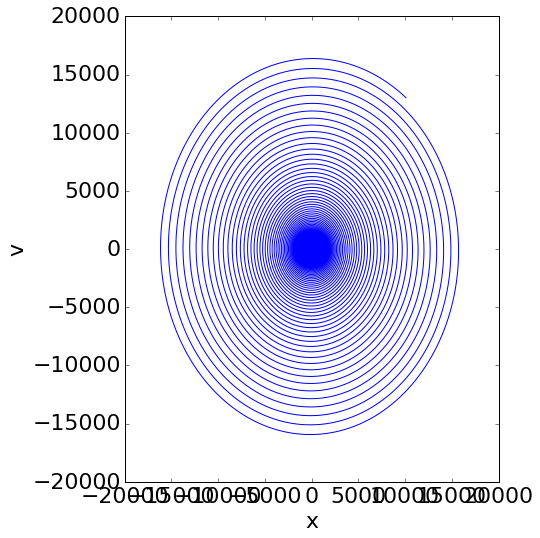

In [325]:
figA, myaxes = plt.subplots(figsize=(8,8))
myaxes.plot(plotX,plotV)
myaxes.set_xlabel('x')
myaxes.set_ylabel('v')
figA.tight_layout()
figA.savefig(str(scheme)+' '+str(timestep)+' '+str(timestop)+' '+str(initialX)+' '+str(initialV)+' xvSpatial.png')

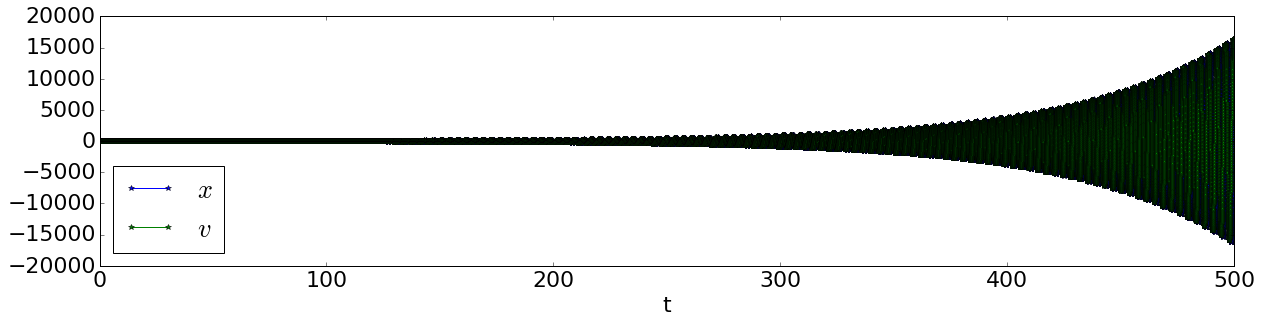

In [326]:
figB, axesB = plt.subplots(figsize=(18,5)) 
axesB.plot(plotT,plotX,'b*-',label='$x$')
axesB.plot(plotT,plotV,'g*-',label='$v$')
axesB.legend(loc=3)
axesB.set_xlabel('t')
axesB.set_xlim(0,timestop)
figB.tight_layout()
figB.savefig(str(scheme)+' '+str(timestep)+' '+str(timestop)+' '+str(initialX)+' '+str(initialV)+' xvTime.png')

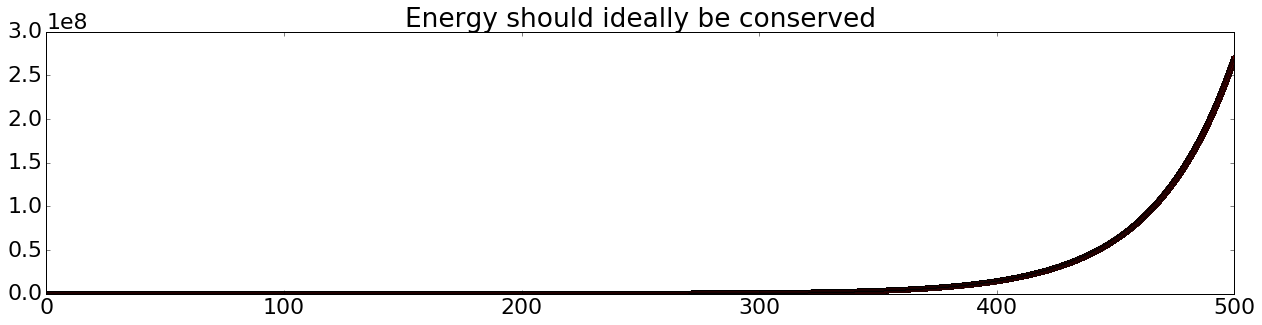

In [327]:
figC, axesC = plt.subplots(figsize=(18,5)) 
axesC.plot(plotT,plotC,'r*-')
axesC.set_title('Energy should ideally be conserved')
axesC.set_xlim(0,timestop)
figC.tight_layout()
figC.savefig(str(scheme)+' '+str(timestep)+' '+str(timestop)+' '+str(initialX)+' '+str(initialV)+' nrg.png')

50000 50000


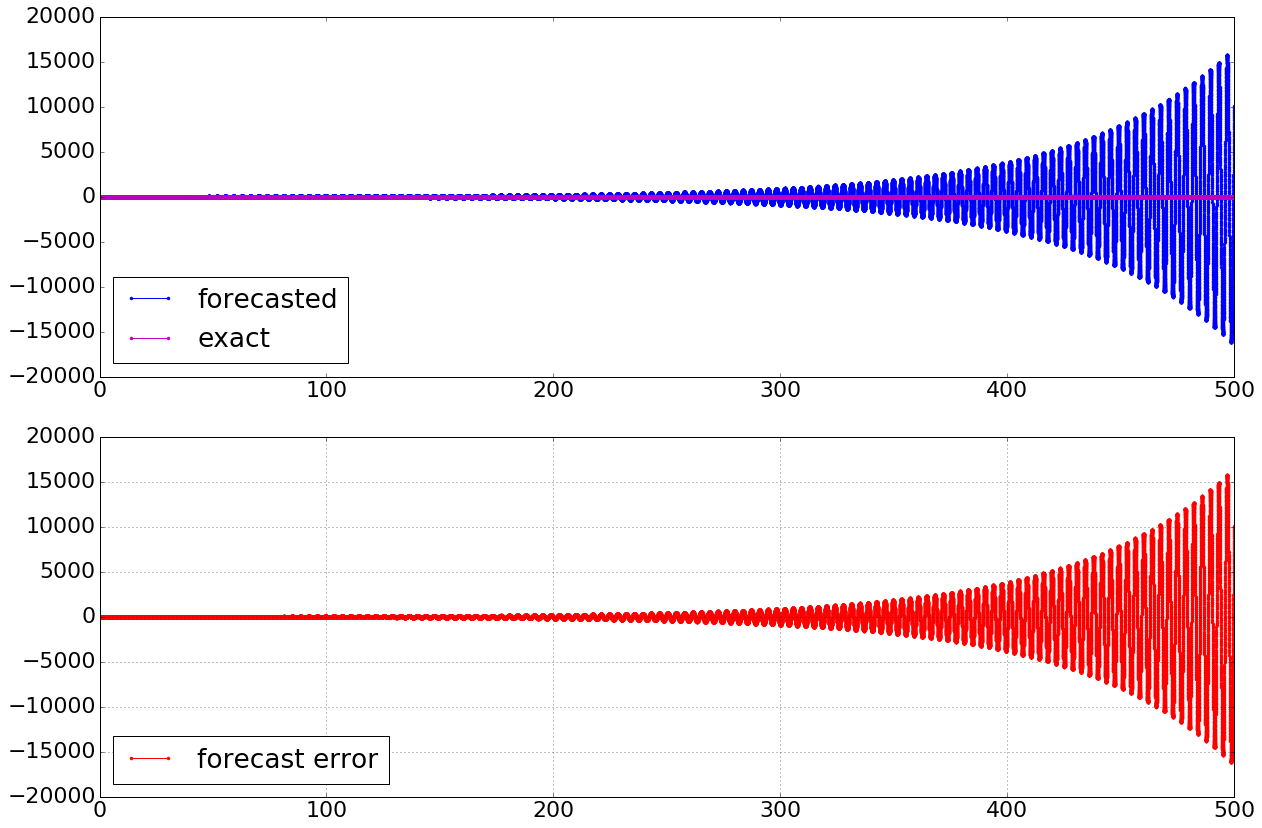

In [328]:
# we can compare with the exact solution, if known
import math
xe = [math.cos(t) for t in plotT] # exact solution for x(t)
error = [a-b for a,b in zip(plotX,xe)]
print (len(error), len(plotT))    
figD, axesD = plt.subplots(nrows=2,ncols=1,figsize=(18,12)) 
axesD[0].plot(plotT,plotX,'b.-',label='forecasted')
axesD[0].plot(plotT,xe,'m.-',label='exact')
#axesD[0].set_ylim(-1.5,1.5)
axesD[0].set_xlim(0,timestop)
axesD[0].legend(loc=3)
axesD[1].plot(plotT,error,'r.-',label='forecast error')
axesD[1].grid()
err=1. # to be used in ylim
axesD[1].set_xlim(0,timestop)
axesD[1].legend(loc=3)
figD.tight_layout()
figD.savefig(str(scheme)+' '+str(timestep)+' '+str(timestop)+' '+str(initialX)+' '+str(initialV)+' forecastComp.png')

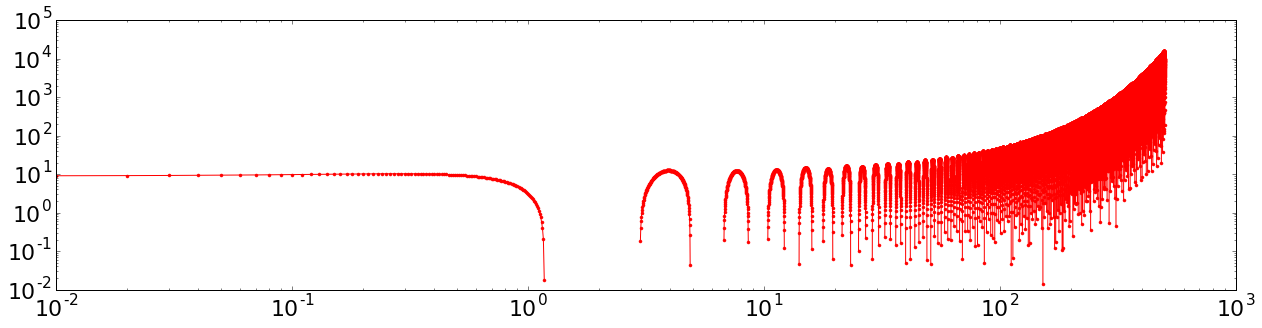

In [329]:
figE, axE = plt.subplots(figsize=(18,5)) 
axE.loglog(plotT,error,'r.-',label='forecast error')
figE.tight_layout()
figE.savefig(str(scheme)+' '+str(timestep)+' '+str(timestop)+' '+str(initialX)+' '+str(initialV)+' loglogerror.png')